In [1]:
# Standard library imports
import sys
import os
import requests
import itertools
import math
from io import StringIO
from tqdm import tqdm
from typing import Tuple

# 3rd-party library imports
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Step 0

In [2]:
'''
Step 0: Downloading Data

Combining diverse inputs into a single dataset

Inputs include:
    - GHCN v4 data
    - ERRST v5 data (later on?)
'''

# Standard library imports
import requests
import sys
import os
from typing import List

# 3rd-party library imports
import pandas as pd
import numpy as np

# Add the parent folder to sys.path
# parent_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
# sys.path.insert(0, parent_dir)

# Local imports
# from parameters.data import GHCN_temp_url, GHCN_meta_url
GHCN_temp_url = 'https://data.giss.nasa.gov/pub/gistemp/ghcnm.tavg.qcf.dat'
GHCN_meta_url = 'https://data.giss.nasa.gov/pub/gistemp/v4.inv'
start_year = 1880

# Local imports
from parameters.data import GHCN_temp_url, GHCN_meta_url

def get_GHCN_data(temp_url: str, meta_url: str) -> pd.DataFrame:
    '''
    Retrieves and formats temperature data from the Global Historical Climatology Network (GHCN) dataset.

    Args:
    temp_url (str): The URL to the temperature data file in GHCN format.
    meta_url (str): The URL to the metadata file containing station information.

    Returns:
    pd.DataFrame: A Pandas DataFrame containing temperature data with station metadata.
    
    This function sends an HTTP GET request to the temperature data URL, processes the data to create
    a formatted DataFrame, replaces missing values with NaN, converts temperature values to degrees Celsius,
    and merges the data with station metadata based on station IDs. The resulting DataFrame includes
    columns for station latitude, longitude, and name, and is indexed by station IDs.
    '''

    try:
        # Send an HTTP GET request to the URL
        response = requests.get(temp_url)

        # Check if the request was successful
        if response.status_code == 200:
            
            # Get the content of the response
            file_data: str = response.content.decode("utf-8")

            # Create a list to store formatted data
            formatted_data = []

            # Loop through file data
            for line in file_data.split('\n'):
                
                # Check if line is not empty
                if line.strip():
                    
                    # Extract relevant data
                    # (Using code from GHCNV4Reader())
                    station_id: str = line[:11]
                    year: int = int(line[11:15])
                    values: List[int] = [int(line[i:i+5]) for i in range(19, 115, 8)]
                    
                    # Append data to list
                    formatted_data.append([station_id, year] + values)

            # Create DataFrame from formatted data
            column_names: List[str] = ['Station_ID', 'Year'] + [f'Month_{i}' for i in range(1, 13)]
            df_GHCN: pd.DataFrame = pd.DataFrame(formatted_data, columns=column_names)
            
            # Replace -9999 with NaN
            df_GHCN.replace(-9999, np.nan, inplace=True)
            
            # Format data - convert to degrees C
            month_columns: List[str] = [f'Month_{i}' for i in range(1, 13)]
            df_GHCN[month_columns] = df_GHCN[month_columns].divide(100)

        else:
            print("Failed to download the file. Status code:", response.status_code)

    except Exception as e:
        print("An error occurred:", str(e))

    # Define the column widths, create meta data dataframe
    column_widths: List[int] = [11, 9, 10, 7, 3, 31]
    df_meta: pd.DataFrame = pd.read_fwf(meta_url, widths=column_widths, header=None,
                          names=['Station_ID', 'Latitude', 'Longitude', 'Elevation', 'State', 'Name'])
    # Merge on station ID, set index
    df: pd.DataFrame = pd.merge(df_GHCN, df_meta[['Station_ID', 'Latitude', 'Longitude', 'Name']], on='Station_ID', how='left')
    df = df.set_index('Station_ID')

    return df

def step0() -> pd.DataFrame:
    '''
    Performs the initial data processing steps for the GHCN temperature dataset.

    Returns:
    pd.DataFrame: A Pandas DataFrame containing filtered and formatted temperature data.
    
    This function retrieves temperature data from the Global Historical Climatology Network (GHCN) dataset,
    processes and formats the data, and returns a DataFrame. The data is first fetched using specified URLs,
    and is returned for further analysis.
    '''
    df_GHCN: pd.DataFrame = get_GHCN_data(GHCN_temp_url, GHCN_meta_url)
    return df_GHCN

In [3]:
step0_output = step0()

In [4]:
step0_output

,Year,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Latitude,Longitude,Name
Station_ID,,,,,,,,,,,,,,,,
ACW00011604,1961,-0.93,2.32,4.68,7.69,11.24,15.95,15.66,14.77,14.09,11.70,5.06,-0.43,57.7667,11.8667,VE
ACW00011604,1962,1.09,0.81,-1.58,6.31,9.04,13.77,15.06,13.89,11.59,9.90,3.19,-1.30,57.7667,11.8667,VE
ACW00011604,1963,-7.17,-5.57,-1.03,5.37,12.20,16.23,16.16,15.92,13.28,9.36,5.62,-1.12,57.7667,11.8667,VE
ACW00011604,1964,0.58,-0.89,0.51,7.34,12.15,14.38,15.02,15.53,12.17,7.84,5.42,1.08,57.7667,11.8667,VE
ACW00011604,1965,0.40,-1.09,0.34,5.86,9.83,14.96,14.83,14.73,13.73,9.70,0.27,-1.82,57.7667,11.8667,VE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIXLT622116,1966,21.80,20.40,18.40,16.90,14.30,12.80,12.10,14.60,17.70,19.80,20.90,21.10,-19.4300,29.7500,ELO
ZIXLT622116,1967,21.10,19.90,18.90,19.20,15.10,13.50,11.00,13.80,16.60,20.80,19.90,19.10,-19.4300,29.7500,ELO
ZIXLT622116,1968,21.80,20.00,19.30,18.20,15.60,10.80,13.70,16.30,17.60,21.80,18.40,20.70,-19.4300,29.7500,ELO


# Step 1

In [5]:
'''
Step 1: Removal of bad data

Drop or adjust certain records (or parts of records).
This includes outliers / out of range reports.
Determined using configuration file.
    <TO-DO> Figure out if this method is ideal.
'''

import pandas as pd
import os
import re
import sys

# Add the parent folder to sys.path
# parent_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
# sys.path.insert(0, parent_dir)

# Local imports
# from parameters.data import drop_rules
drop_rules = '''
CHM00052836  omit: 0-1948
CHXLT909860  omit: 0-1950
BL000085365  omit: 0-1930
MXXLT948335  omit: 0-1952
ASN00058012  omit: 0-1899
ASN00084016  omit: 0-1899
ASN00069018  omit: 0-1898
NIXLT013080  omit: 0-1930
NIXLT751359  omit: 0-9999
CHXLT063941  omit: 0-1937
CHM00054843  omit: 0-1937
MXM00076373  omit: 0-9999
USC00044022  omit: 0-9999
USC00044025  omit: 0-9999
CA002402332  omit: 2011-9999
RSM00024266  omit: 2021/09
'''


def filter_coordinates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters a DataFrame based on latitude and longitude conditions.

    Args:
    df (pd.DataFrame): The input DataFrame with 'Latitude' and 'Longitude' columns.

    Returns:
    pd.DataFrame: The filtered DataFrame with rows where latitude is between -90 and 90,
    and longitude is between -180 and 180.
    """
    
    # Define latitude and longitude range conditions
    lat_condition = (df['Latitude'] >= -90) & (df['Latitude'] <= 90)
    lon_condition = (df['Longitude'] >= -180) & (df['Longitude'] <= 180)

    # Apply the conditions to filter the DataFrame
    df_filtered = df[lat_condition & lon_condition]
    
    # Calculate number of rows filtered
    num_filtered = len(df) - len(df_filtered)
    print(f'Number of rows with invalid coordinates (removed): {num_filtered}')

    return df_filtered

def filter_stations_by_rules(dataframe: pd.DataFrame, rules_text: str) -> pd.DataFrame:
    """
    Filters a DataFrame of climate station data based on exclusion rules specified in a text format.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame containing climate station data.
        rules_text (str): A string containing exclusion rules for specific stations and years.

    Returns:
        pd.DataFrame: A filtered DataFrame with stations omitted based on the provided rules.

    Rules Format:
        The 'rules_text' should be formatted as follows:
        - Each rule is represented as a single line in the text.
        - Each line should start with the station ID followed by exclusion rules.
        - Exclusion rules consist of 'omit:' followed by the years to exclude, e.g., 'omit: 2000-2010'.
        - Years can be specified as a single year (e.g., 'omit: 2000') or as a range (e.g., 'omit: 2000-2010').
        - Year ranges can also be specified using '/' (e.g., 'omit: 2000/2002').

    Example:
        rules_text = '''
            CHM00052836  omit: 0-1948
            CHXLT909860  omit: 0-1950
            BL000085365  omit: 0-1930
            ...
        '''

    This function takes the provided rules and applies them to the input DataFrame,
    resulting in a new DataFrame with stations excluded based on the specified rules.
    """

    # Parse the rules from the provided text
    rules = {}
    for line in rules_text.split('\n'):
        if line.strip():
            match = re.match(r'([A-Z0-9]+)\s+omit:\s+(\S+)', line)
            if match:
                station_id, year_rule = match.groups()
                rules[station_id] = year_rule

    # Create a mask to identify rows to omit
    mask = pd.Series(True, index=dataframe.index)

    for station_id, year_rule in rules.items():
        try:
            # Split the year_rule into start and end years
            start_year, end_year = map(int, year_rule.split('-'))
        except ValueError:
            # Handle cases like '2011/12' or '2012-9999'
            if '/' in year_rule:
                start_year = int(year_rule.split('/')[0])
                end_year = start_year
            elif '-' in year_rule:
                start_year = int(year_rule.split('-')[0])
                end_year = int(year_rule.split('-')[1])
            else:
                continue

        # Update the mask to False for the specified range of years for the station_id
        mask &= ~((dataframe['Year'] >= start_year) & (dataframe['Year'] <= end_year) & (dataframe.index == station_id))

    # Apply the mask to filter the DataFrame
    filtered_dataframe = dataframe[mask]

    # Calculate number of rows filtered
    num_filtered = len(dataframe) - len(filtered_dataframe)
    print(f'Number of rows removed according to station exclusion rules: {num_filtered}')

    return filtered_dataframe

def step1(step0_output: pd.DataFrame) -> pd.DataFrame:
    """
    Applies data filtering and cleaning operations to the input DataFrame.

    Parameters:
        step0_output (pd.DataFrame): The initial DataFrame containing climate station data.

    Returns:
        pd.DataFrame: A cleaned and filtered DataFrame ready for further analysis.

    This function serves as a data processing step by applying two essential filtering operations:
    1. `filter_coordinates`: Filters the DataFrame based on geographical coordinates, retaining relevant stations.
    2. `filter_stations_by_rules`: Filters the DataFrame based on exclusion rules, omitting specified stations and years.

    The resulting DataFrame is cleaned of irrelevant stations and years according to specified rules
    and is ready for subsequent data analysis or visualization.
    """
        
    df_filtered = filter_coordinates(step0_output)
    df_clean = filter_stations_by_rules(df_filtered, drop_rules)
    return df_clean

In [6]:
step1_output = step1(step0_output)

Number of rows with invalid coordinates (removed): 0
Number of rows removed according to station exclusion rules: 524


In [7]:
step1_output

,Year,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Latitude,Longitude,Name
Station_ID,,,,,,,,,,,,,,,,
ACW00011604,1961,-0.93,2.32,4.68,7.69,11.24,15.95,15.66,14.77,14.09,11.70,5.06,-0.43,57.7667,11.8667,VE
ACW00011604,1962,1.09,0.81,-1.58,6.31,9.04,13.77,15.06,13.89,11.59,9.90,3.19,-1.30,57.7667,11.8667,VE
ACW00011604,1963,-7.17,-5.57,-1.03,5.37,12.20,16.23,16.16,15.92,13.28,9.36,5.62,-1.12,57.7667,11.8667,VE
ACW00011604,1964,0.58,-0.89,0.51,7.34,12.15,14.38,15.02,15.53,12.17,7.84,5.42,1.08,57.7667,11.8667,VE
ACW00011604,1965,0.40,-1.09,0.34,5.86,9.83,14.96,14.83,14.73,13.73,9.70,0.27,-1.82,57.7667,11.8667,VE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIXLT622116,1966,21.80,20.40,18.40,16.90,14.30,12.80,12.10,14.60,17.70,19.80,20.90,21.10,-19.4300,29.7500,ELO
ZIXLT622116,1967,21.10,19.90,18.90,19.20,15.10,13.50,11.00,13.80,16.60,20.80,19.90,19.10,-19.4300,29.7500,ELO
ZIXLT622116,1968,21.80,20.00,19.30,18.20,15.60,10.80,13.70,16.30,17.60,21.80,18.40,20.70,-19.4300,29.7500,ELO


# Step 2

In [8]:
# Skip for now

# Step 3

In [9]:
'''
Step 3: Gridding of cells

There are 8000 cells across the globe.
Each cell's values are computed using station records within a 1200km radius.
    - Contributions are weighted according to distance to cell center
    (linearly decreasing to 0 at distance 1200km)
'''

import math
from typing import Tuple

import numpy as np
import pandas as pd
from pandas import Series


def calculate_area(row: Series) -> float:
    earth_radius_km: float = 6371.0
    delta_longitude: float = np.radians(row['Eastern'] - row['Western'])
    southern_latitude: float = np.radians(row['Southern'])
    northern_latitude: float = np.radians(row['Northern'])
    area: float = (earth_radius_km ** 2) * delta_longitude * (np.sin(northern_latitude) - np.sin(southern_latitude))
    return area


def calculate_center_coordinates(row: pd.Series) -> Tuple[float, float]:
    """Calculate the center latitude and longitude for a given box.

    Args:
        row (pd.Series): A Pandas Series representing a row of the DataFrame with ('southern', 'northern', 'western', 'eastern') coordinates.

    Returns:
        Tuple[float, float]: A tuple containing the center latitude and longitude.
    """
    center_latitude = 0.5 * (math.sin(row['Southern'] * math.pi / 180) + math.sin(row['Northern'] * math.pi / 180))
    center_longitude = 0.5 * (row['Western'] + row['Eastern'])
    center_latitude = math.asin(center_latitude) * 180 / math.pi
    return center_latitude, center_longitude


def generate_80_cell_grid() -> pd.DataFrame:
    """Generate an 80-cell grid DataFrame with columns for southern, northern, western, eastern,
    center_latitude, and center_longitude coordinates.

    Returns:
        pd.DataFrame: The generated DataFrame.
    """
    grid_data = []
    
    # Number of horizontal boxes in each band
    # (proportional to the thickness of each band)
    band_boxes = [4, 8, 12, 16]
    
    # Sines of latitudes
    band_altitude = [1, 0.9, 0.7, 0.4, 0]

    # Generate the 40 cells in the northern hemisphere
    for band in range(len(band_boxes)):
        n = band_boxes[band]
        for i in range(n):
            lats = 180 / math.pi * math.asin(band_altitude[band + 1])
            latn = 180 / math.pi * math.asin(band_altitude[band])
            lonw = -180 + 360 * float(i) / n
            lone = -180 + 360 * float(i + 1) / n
            box = (lats, latn, lonw, lone)
            grid_data.append(box)

    # Generate the 40 cells in the southern hemisphere by reversing the northern hemisphere cells
    for box in grid_data[::-1]:
        grid_data.append((-box[1], -box[0], box[2], box[3]))

    # Create a DataFrame from the grid data
    df = pd.DataFrame(grid_data, columns=['Southern', 'Northern', 'Western', 'Eastern'])

    # Calculate center coordinates for each box and add them as new columns
    center_coords = df.apply(calculate_center_coordinates, axis=1)
    df[['Center_Latitude', 'Center_Longitude']] = pd.DataFrame(center_coords.tolist(), index=df.index)

    return df
    

def interpolate(x: float, y: float, p: float) -> float:
    return y * p + (1 - p) * x


def generate_8000_cell_grid(grid_80):

    # Initialize an empty list to store subboxes
    subbox_list = []

    for index, row in grid_80.iterrows():
        alts = math.sin(row['Southern'] * math.pi / 180)
        altn = math.sin(row['Northern'] * math.pi / 180)

        for y in range(10):
            s = 180 * math.asin(interpolate(alts, altn, y * 0.1)) / math.pi
            n = 180 * math.asin(interpolate(alts, altn, (y + 1) * 0.1)) / math.pi
            for x in range(10):
                w = interpolate(row['Western'], row['Eastern'], x * 0.1)
                e = interpolate(row['Western'], row['Eastern'], (x + 1) * 0.1)

                # Create a DataFrame for the subbox
                subbox_df = pd.DataFrame({'Southern': [s], 'Northern': [n], 'Western': [w], 'Eastern': [e]})

                # Append the subbox DataFrame to the list
                subbox_list.append(subbox_df)

    # Concatenate all subboxes into a single DataFrame
    grid_8000 = pd.concat(subbox_list, ignore_index=True)

    # Calculate center coordinates for each box and add them as new columns
    center_coords = grid_8000.apply(calculate_center_coordinates, axis=1)
    grid_8000[['Center_Latitude', 'Center_Longitude']] = pd.DataFrame(center_coords.tolist(), index=grid_8000.index)

    # Calculate area of all 8000 cells
    grid_8000['Area'] = grid_8000.apply(calculate_area, axis=1)

    # Print the resulting DataFrame
    return grid_8000

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the spherical distance (in kilometers) between two pairs of
    latitude and longitude coordinates using the Haversine formula.

    Args:
        lat1 (float): Latitude of the first point in degrees.
        lon1 (float): Longitude of the first point in degrees.
        lat2 (float): Latitude of the second point in degrees.
        lon2 (float): Longitude of the second point in degrees.

    Returns:
        float: Spherical distance in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Radius of the Earth in kilometers
    radius: float = 6371.0  # Earth's mean radius

    # Haversine formula
    dlat: float = lat2 - lat1
    dlon: float = lon2 - lon1

    a: float = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c: float = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance: float = radius * c

    return distance


def linearly_decreasing_weight(distance: float, max_distance: float) -> float:
    """
    Calculate a linearly decreasing weight based on the given distance
    and maximum distance.

    Args:
        distance (float): The distance at which you want to calculate the weight.
        max_distance (float): The maximum distance at which the weight becomes 0.

    Returns:
        float: The linearly decreasing weight, ranging from 1 to 0.
    """
    # Ensure that distance is within the valid range [0, max_distance]
    distance: float = max(0, min(distance, max_distance))

    # Calculate the weight as a linear interpolation
    weight: float = 1.0 - (distance / max_distance)
    
    return weight

def normalize_dict_values(d):
    # Calculate the sum of all values in the dictionary
    total = sum(d.values())
    
    # Check if the total is not zero to avoid division by zero
    if total != 0:
        # Normalize each value by dividing by the total
        normalized_dict = {key: value / total for key, value in d.items()}
        return normalized_dict
    else:
        # Handle the case where the total is zero (all values are zero)
        return d  # Return the original dictionary

def nearby_stations(grid_df, station_df):

    # Initialize an empty list to store station IDs and weights as dictionaries
    station_weights_within_radius = []

    # Maximum distance for the weight calculation (e.g., 1200.0 km)
    max_distance = 1200.0

    # Use tqdm to track progress
    for index, row in tqdm(grid_df.iterrows(), total=len(grid_df), desc="Processing"):
        center_lat = row['Center_Latitude']
        center_lon = row['Center_Longitude']

        # Calculate distances for each station in station_df
        distances = station_df.apply(lambda x: haversine_distance(center_lat, center_lon, x['Latitude'], x['Longitude']), axis=1)

        # Find station IDs within the specified radius
        nearby_stations = station_df[distances <= max_distance]

        # Calculate weights for each nearby station
        weights = nearby_stations.apply(lambda x: linearly_decreasing_weight(distances[x.name], max_distance), axis=1)

        # Create a dictionary of station IDs and weights
        station_weights = dict(zip(nearby_stations['Station_ID'], weights))
        
        # Normalize weights to sum to 1
        station_weights = normalize_dict_values(station_weights)

        # Append the dictionary to the result list
        station_weights_within_radius.append(station_weights)

    # Add the list of station IDs and weights as a new column
    grid_df['Nearby_Stations'] = station_weights_within_radius

    # Set index name
    grid_df.index.name = 'Box_Number'
    
    return grid_df

In [10]:
# Create 80 cell grid (boxes)
grid_80 = generate_80_cell_grid()
grid_80['Area'] = grid_80.apply(calculate_area, axis=1)

# Create 8000 cell grid (subboxes)
grid_8000 = generate_8000_cell_grid(grid_80)
grid_8000['Area'] = grid_8000.apply(calculate_area, axis=1)

# Create station metadata dataframe
meta_url = 'https://data.giss.nasa.gov/pub/gistemp/v4.inv'
column_widths: List[int] = [11, 9, 10, 7, 3, 31]
station_df: pd.DataFrame = pd.read_fwf(meta_url, widths=column_widths, header=None,
                          names=['Station_ID', 'Latitude', 'Longitude', 'Elevation', 'State', 'Name'])

In [11]:
grid_80 = nearby_stations(grid_80, station_df)

Processing: 100%|███████████████████████████████| 80/80 [00:06<00:00, 12.31it/s]


In [12]:
# grid_8000 = nearby_stations(grid_8000, station_df)
# grid_8000.to_csv('grid_8000.csv')

In [13]:
# Load in 8000 cell grid
grid_8000 = pd.read_csv('grid_8000.csv')
grid_8000 = grid_8000.set_index('Box_Number')

# Step 4: SST Data

In [14]:
# Skipping for now
# Should be consolidated into step 0 / 1

# Step 5: Anomalyzing Data (yearRow algorithm)

Aside: need to figure out what to do about missing data in 1951

- Calculate monthly averages for each station (DRAFT)
- Use monthly averages to calculate yearly anomalies for each station (DRAFT)
- Create a gridded anomaly dataframe
    - For each cell:
        - Collect all anomalies from stations within 1200 kilometers (and their weights) (DRAFT)
        - Multiply each station's rows by their weights (DRAFT)
        - Sum the rows for the same year (DRAFT)
        - That's the time series for the cell (DRAFT)
            - (NOTE: each cell will be a dataframe, rather than a single row)
    
    - (DIFFICULT TO DO EFFICIENTLY/QUICKLY)

In [17]:
def calculate_monthly_averages(df, start_year, end_year):
    
    # Copy output from step 1
    df = step1_output.copy()

    # Collect list of all stations
    all_stations = sorted(list(df.index.unique()))

    # Create dataframe of only monthly temperature values
    station_months = df.drop(columns=['Latitude', 'Longitude', 'Name'])

    # Initialize an empty list to store DataFrames
    dfs = []

    for station_i in tqdm(all_stations):
        monthly_values = station_months.loc[station_i]
        baseline_yearly_averages = monthly_values[(monthly_values['Year'] >= start_year) & (monthly_values['Year'] <= end_year)]
        baseline_monthly_averages = baseline_yearly_averages.drop(columns=['Year']).mean()
        dfs.append(baseline_monthly_averages)

    # Concatenate all DataFrames in the list
    monthly_station_averages = pd.concat(dfs, axis=1).T

    # Set the index to station_i for each row
    monthly_station_averages.index = all_stations
    
    return monthly_station_averages

def calculate_anomalies(df, monthly_averages_df):
    
    # Calculate temperature anomalies for each station and each month
    anomalies = df.iloc[:, 1:13] - monthly_averages_df

    # Add the 'Year', 'Latitude', 'Longitude', and 'Name' columns back to the anomalies DataFrame
    anomalies[['Year', 'Latitude', 'Longitude', 'Name']] = df[['Year', 'Latitude', 'Longitude', 'Name']]

    # Set the index of the anomalies DataFrame to match the original station IDs
    anomalies.index = df.index

    return anomalies

def calculate_8000_cell_anomaly(anomaly_df):
    
    # Suppress the SettingWithCopyWarning
    pd.options.mode.chained_assignment = None

    monthly_columns = []
    for i in range(1, 13):
        monthly_columns.append('Month_' + str(i))

    anomaly_8000 = []
    for i in tqdm(range(len(grid_8000))):
        cell = grid_8000.iloc[i]

        station_dict = eval(cell['Nearby_Stations'])
        df_weighted = anomaly_df.loc[anomaly_df.index.isin(station_dict.keys())]

        for station_id, weight in station_dict.items():
            if station_id in df_weighted.index:
                df_weighted.loc[station_id, monthly_columns] = df_weighted.loc[station_id, monthly_columns] * weight

        yearly_anomaly = df_weighted.groupby('Year').sum(numeric_only=True).reset_index()
        anomaly_8000.append(yearly_anomaly)
    return anomaly_8000
        
def add_box_number_column(grid_8000, grid_80):
    # Initialize an empty list to store box numbers
    box_numbers = []

    # Iterate through each cell in the grid_8000 DataFrame
    for index, row in grid_8000.iterrows():
        # Get the latitude and longitude of the center of the cell
        cell_latitude = row['Center_Latitude']
        cell_longitude = row['Center_Longitude']

        # Find the box in grid_80 that contains this cell
        for box_number, box_row in grid_80.iterrows():
            if (
                box_row['Southern'] <= cell_latitude <= box_row['Northern'] and
                box_row['Western'] <= cell_longitude <= box_row['Eastern']
            ):
                box_numbers.append(box_number)
                break  # No need to check other boxes

    # Add the box numbers as a new column to grid_8000
    grid_8000['Box_Number'] = box_numbers

    return grid_8000

def calculate_80_cell_anomaly(anomaly_8000):
    df = anomaly_8000.copy()
    anomaly_80 = []

    for box in tqdm(range(len(grid_80))):
        box_dfs = df[box:(box+1)*100]

        dfs_with_source = [(df, source) for source, df in enumerate(box_dfs)]
        concatenated_dfs = [df.assign(Source=source) for df, source in dfs_with_source]
        concatenated_df = pd.concat(concatenated_dfs)

        # Group by 'Year' and calculate the mean for each year
        grouped = concatenated_df.groupby('Year')

        # Calculate the mean for each year while ignoring NaN values
        average_df = grouped.mean(numeric_only=True)

        # Reset the index to have 'Year' as a regular column
        average_df = average_df.reset_index()

        anomaly_80.append(average_df)
        
    return anomaly_80

In [18]:
# Calculate monthly averages
monthly_averages_df = calculate_monthly_averages(step1_output, 1951, 1980)

# Calculate anomalies for all stations / years
anomaly_df = calculate_anomalies(step1_output, monthly_averages_df)

# Create list of dataframes for anomalies for 8000 cell grid
anomaly_8000 = calculate_8000_cell_anomaly(anomaly_df)

# Add box number to each dataframe in anomaly_8000 list
#grid_8000 = add_box_number_column(grid_8000, grid_80)
#anomaly_8000 = [df.assign(Box_Number=grid_8000['Box_Number']) for df in anomaly_8000]

# Create list of dataframes for anomalies for 80 cell grid
anomaly_80 = calculate_80_cell_anomaly(anomaly_8000)

100%|███████████████████████████████████████████| 80/80 [00:39<00:00,  2.04it/s]


In [22]:
anomaly_8000[0]

,Year,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Latitude,Longitude
0,1839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014430,0.007909,0.008006,-0.006398,-0.017866,57.1553,-170.2222
1,1840,-0.023147,0.018797,-0.005059,0.004945,0.000136,0.001689,0.007981,-0.000403,-0.002771,-0.008608,-0.021232,-0.050500,57.1553,-170.2222
2,1841,-0.007719,-0.022144,-0.041254,0.013252,-0.007577,-0.002464,0.003234,-0.001590,-0.000991,-0.009201,-0.017079,-0.029733,57.1553,-170.2222
3,1842,-0.051627,-0.064865,0.000281,-0.014042,-0.012324,-0.014331,-0.007447,-0.009897,-0.006924,-0.006234,-0.004618,-0.011339,57.1553,-170.2222
4,1843,-0.068241,-0.019770,0.007994,-0.010482,-0.005797,-0.004244,-0.000920,-0.003370,-0.000991,0.005633,-0.006398,-0.024393,57.1553,-170.2222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2019,-0.135784,2.049331,1.408328,0.962735,0.573144,0.806384,0.459228,0.286024,0.460434,0.645101,1.083966,1.188695,4557.5175,-7200.2425
151,2020,-0.342013,-0.482140,1.066643,0.689938,0.501524,0.511391,0.126919,0.192025,0.316376,1.096034,1.604125,0.906979,4680.0961,-7837.7761
152,2021,-0.091628,0.142655,0.069941,0.516358,0.406001,0.367842,0.027391,-0.134712,-0.227872,0.125336,-0.289356,0.369430,4156.4822,-6580.6955
153,2022,-0.240407,0.399310,1.343421,1.014020,0.660359,0.337941,-0.078175,-0.048633,0.312697,0.397561,0.735196,1.568744,4417.7875,-7535.8186


In [23]:
anomaly_80[0]

,Year,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Latitude,Longitude,Source
0,1768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.800000,-94.000000,19.625000
1,1769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.800000,-94.000000,19.625000
2,1774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,57.000000,-92.300000,16.600000
3,1775,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,57.000000,-92.300000,16.600000
4,1776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,57.000000,-92.300000,16.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2019,0.345431,1.344424,1.635074,0.443227,0.679776,0.457883,0.308756,0.229139,0.642497,1.015959,0.985077,0.833929,5862.814260,-11824.209318,49.090909
221,2020,-0.115655,-0.115044,0.514768,0.682888,0.310074,0.432401,0.147068,0.223943,0.322784,0.781347,0.727376,0.799195,5941.512516,-12080.216248,49.090909
222,2021,0.830500,0.158195,0.360250,0.583310,0.251487,0.349771,0.114235,0.026406,0.286828,1.135181,0.414355,0.514596,5764.728961,-11551.189734,49.090909
223,2022,0.227836,0.222603,1.029208,0.347086,0.373229,0.313193,0.247147,0.236943,0.455133,0.638332,0.605486,0.911472,5829.024889,-11755.593016,49.090909


# MISC

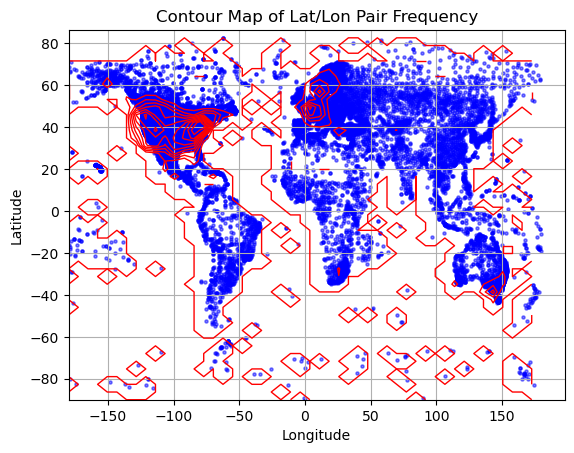

In [62]:
plt.scatter(lons, lats, s=5, c='blue', alpha=0.5, marker='o')
plt.grid()

# Add contour lines based on the point density
x_bins = np.linspace(-180, 180, 50)
y_bins = np.linspace(-90, 90, 50)
H, xedges, yedges = np.histogram2d(lons, lats, bins=(x_bins, y_bins))
plt.contour(xedges[:-1], yedges[:-1], H.T, levels=10, colors='red', linewidths=1)

# Customize labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Contour Map of Lat/Lon Pair Frequency')

# Show the plot
plt.show()

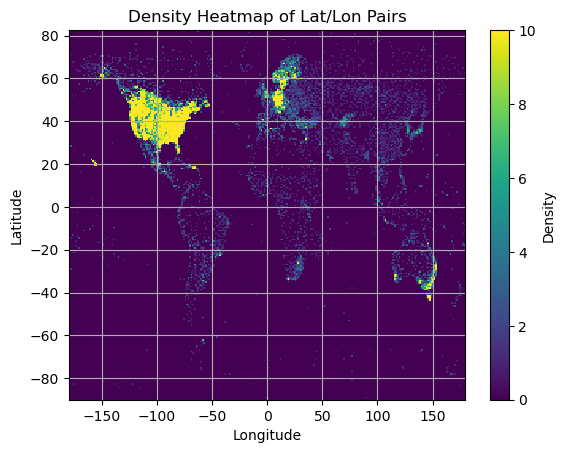

In [84]:
# Create a density heatmap using plt.hist2d
plt.hist2d(lons, lats, bins=250, cmap='viridis', vmin=0, vmax=10)

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Density')

# Customize labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Density Heatmap of Lat/Lon Pairs')

# Show the plot
plt.grid()
plt.show()

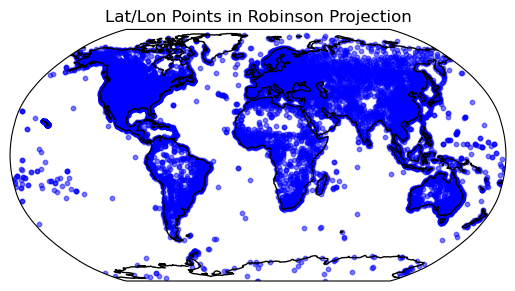

In [87]:
# Create a figure with a Robinson projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=0)})

# Plot the latitude and longitude data in the Robinson projection
ax.scatter(lons, lats, s=10, c='blue', alpha=0.5, transform=ccrs.PlateCarree())

# Add coastlines for reference
ax.coastlines()

# Customize labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Lat/Lon Points in Robinson Projection')

# Show the plot
plt.show()